# Model training
This notebook contains the preparation of the training, the training itself and the analysis of the training results.

In [1]:
# Imports
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Training preparation

In [2]:
df = pd.read_csv("./../data_works/train_set_pipeline/stock_data.csv", low_memory=False, index_col=0)
df.head()

,meme_stock,ticker,price_2020-12-01,wsv_2020-12-01,price_2020-12-16,wsv_2020-12-16,price_2021-01-04,wsv_2021-01-04,price_2021-01-20,wsv_2021-01-20,...,volume,fiftyTwoWeekHigh,fiveYearAvgDividendYield,fiftyTwoWeekLow,bid,tradeable,dividendYield,bidSize,dayHigh,fax
0,True,GME,4.277500,86,3.490000,20,4.750000,91,9.342500,597,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,True,AMC,4.430000,1,2.870000,1,2.200000,2,3.290000,44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,True,BBBY,21.290001,0,19.430000,0,17.969999,3,25.110001,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,True,FIZZ,43.345825,0,38.819767,0,40.557332,0,44.121933,1,...,304714.0,57.65,NaN,38.1,47.31,False,NaN,800.0,53.98,NaN
4,True,BB,8.360000,44,8.350000,4,6.700000,3,13.230000,430,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# df[df.ticker.apply(lambda x: not x.isnumeric())]
cols_to_drop = ["city", "state", "country", "financialCurrency", "shortName", "longName", "exchangeTimezoneShortName",\
    "isEsgPopulated", "quoteType", "market", "morningStarRiskRating", "fundInceptionDate", "lastFiscalYearEnd", "mostRecentQuarter",\
        "legalType", "lastDividendDate", "startDate", "fax", "zip"]
cols_to_encode = ["sector", "industry", "recommendationKey", "exchange", "fundFamily", "tradeable"]
# These have overfitting potential: industry
dummies = pd.get_dummies(df[cols_to_encode])
df = pd.concat([df, dummies], axis=1)

In [4]:
# These feature are potentially needed later on, but not for training
y = df["meme_stock"]
cols_to_drop += ["logo_url", "ticker", "meme_stock"]
df.drop(cols_to_drop+cols_to_encode, axis=1, inplace=True)
X = df.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

## Hyperparameter tuning

In [5]:
xgb.config_context(verbosity=0)

In [6]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

# Adjust function from hyperopt package to return integers instead of floats (error in the package)
from hyperopt.pyll import scope
from hyperopt.pyll_utils import validate_label, validate_distribution_range

@validate_label
@validate_distribution_range
def quniform(label, *args, **kwargs):
    return scope.int(scope.hyperopt_param(label, scope.quniform(*args, **kwargs)))

space = {
    'max_depth': hp.quniform("max_depth", 5, 15, 1),
    'learning_rate': hp.uniform("learning_rate", 0.01, 0.5),
    'grow_policy': hp.choice("grow_policy", ["depthwise", "lossguide"]),
    'seed': hp.randint("seed", 100),
    'objective': 'binary:logistic',
}
evallist = [(dtrain, 'train'), (dtest, 'eval')]

In [7]:
def hyperparameter_tuning(space):
    """ Perform hyperparameter tuning with given hyperparameter space. """

    evals_result = {}
    model = xgb.train(space, dtrain, 10, evallist, evals_result=evals_result)

    return {'loss': evals_result["eval"]["logloss"][-1], 'status': STATUS_OK, 'model': model}

In [8]:
# Run Optimization
trials = Trials()
best_params = fmin(fn=hyperparameter_tuning, space=space, algo=tpe.suggest, max_evals=150, trials=trials)
best_params

[0]	train-logloss:0.60938	eval-logloss:0.62741         
[1]	train-logloss:0.55577	eval-logloss:0.57738         
[2]	train-logloss:0.50995	eval-logloss:0.54394         
[3]	train-logloss:0.46553	eval-logloss:0.50548         
[4]	train-logloss:0.42912	eval-logloss:0.47893         
[5]	train-logloss:0.40289	eval-logloss:0.45672         
[6]	train-logloss:0.38258	eval-logloss:0.44570         
[7]	train-logloss:0.35878	eval-logloss:0.43242         
[8]	train-logloss:0.34392	eval-logloss:0.42312         
[9]	train-logloss:0.32769	eval-logloss:0.41539         
  1%|          | 1/150 [00:00<00:23,  6.43trial/s, best loss: 0.4153923225402832]

c:\Users\janhe\Desktop\Uni\Fallstudie_DS\stonkscast\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



[0]	train-logloss:0.50734	eval-logloss:0.55141                                   
[1]	train-logloss:0.42593	eval-logloss:0.48137                                   
[2]	train-logloss:0.35453	eval-logloss:0.42919                                   
[3]	train-logloss:0.31194	eval-logloss:0.40903                                   
[4]	train-logloss:0.27197	eval-logloss:0.36481                                   
[5]	train-logloss:0.23683	eval-logloss:0.33699                                   
[6]	train-logloss:0.21490	eval-logloss:0.31303                                   
[7]	train-logloss:0.19446	eval-logloss:0.31679                                   
[8]	train-logloss:0.18062	eval-logloss:0.29935                                   
[9]	train-logloss:0.16596	eval-logloss:0.29151                                   
[0]	train-logloss:0.50460	eval-logloss:0.54946                                   
[1]	train-logloss:0.42294	eval-logloss:0.47944                                   
[2]	train-loglos

{'grow_policy': 1,
 'learning_rate': 0.4215920307971097,
 'max_depth': 6.0,
 'seed': 82}

## Model training
Training a final XGB model with best hyperparameters from hyperparameter tuning.

In [9]:
# Set hyperparameters
param = {
    'max_depth': 10, # Huge number of features require complex model
    'objective': 'binary:logistic',
}

In [10]:
evals_result = {}
best_params["grow_policy"] = ["depthwise", "lossguide"][best_params["grow_policy"]] if isinstance(best_params["grow_policy"], np.int64) else best_params["grow_policy"]
best_params["max_depth"] = int(best_params["max_depth"])
best_params["objective"] = "binary:logistic"
model = xgb.train(best_params, dtrain, 10, evallist, evals_result=evals_result)

[0]	train-logloss:0.48667	eval-logloss:0.53683
[1]	train-logloss:0.40397	eval-logloss:0.46762
[2]	train-logloss:0.35209	eval-logloss:0.43557
[3]	train-logloss:0.29994	eval-logloss:0.37963
[4]	train-logloss:0.25617	eval-logloss:0.32887
[5]	train-logloss:0.22602	eval-logloss:0.30769
[6]	train-logloss:0.19985	eval-logloss:0.28271
[7]	train-logloss:0.18035	eval-logloss:0.26492
[8]	train-logloss:0.16597	eval-logloss:0.25800
[9]	train-logloss:0.15301	eval-logloss:0.25081


## Inference

In [11]:

prediction_results_df = pd.DataFrame(X_test)
prediction_results_df["label"] = list(y_test)
prediction_results_df["prediction"] = model.predict(dtest)
prediction_results_df.head(30)

,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,label,prediction
0,7.399025,0.0,7.339356,0.0,6.842109,0.0,9.547129,0.0,NaN,1.4714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.133500
1,15.806712,0.0,15.967212,0.0,16.160985,0.0,16.463278,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.061334
2,286.329987,0.0,302.070007,0.0,294.739990,0.0,286.470001,0.0,389.680,NaN,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,False,0.100332
3,22.230000,0.0,21.580000,0.0,20.850000,0.0,21.250000,0.0,11.880,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,False,0.437958
4,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.057048
5,23.600381,0.0,23.332686,0.0,23.401767,0.0,23.531296,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.027381
6,11.480000,1.0,13.490000,3.0,14.890000,1.0,17.780001,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0.849620
7,56.892667,0.0,56.567790,0.0,57.893802,0.0,56.557560,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.056623
8,355.199188,0.0,344.383275,0.0,342.195070,0.0,330.203072,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.026202
9,0.780000,0.0,1.040000,0.0,1.420000,0.0,3.200000,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.126104


In [12]:
# Prediction analysis
label = prediction_results_df["label"]
prediction = [prediction > 0.7 for prediction in prediction_results_df["prediction"]]
print(f"Accuracy: {accuracy_score(label, prediction)}")
print(f"Precision: {precision_score(label, prediction)}")
print(f"Recall: {recall_score(label, prediction)}")
print(f"F1-Score: {f1_score(label, prediction)}")

Accuracy: 0.92
Precision: 0.6666666666666666
Recall: 1.0
F1-Score: 0.8


## Model analysis
Analysing the feature importance to better understand dependencies in the data and to condense the dataset down to the relevant features for performant handling in production later on.

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

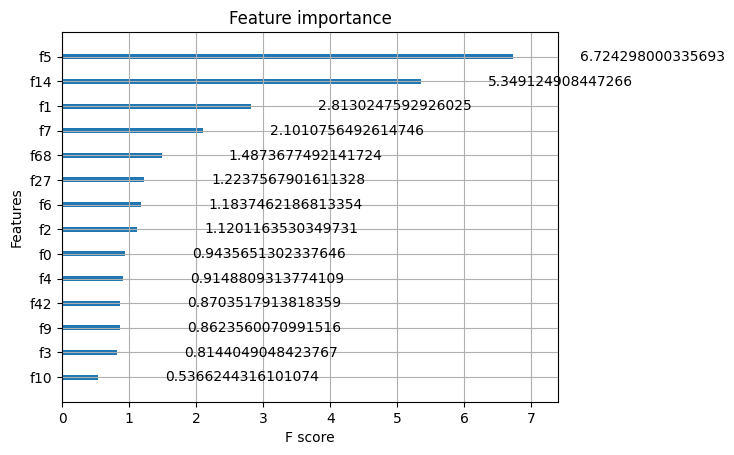

In [12]:
xgb.plot_importance(model, importance_type="gain")

In [13]:
for idx, col in enumerate(list(df.columns)):
    print(f"{idx}: {col}")

0: price_2020-12-01
1: wsv_2020-12-01
2: price_2020-12-16
3: wsv_2020-12-16
4: price_2021-01-04
5: wsv_2021-01-04
6: price_2021-01-20
7: wsv_2021-01-20
8: regularMarketPrice
9: trailingPegRatio
10: fullTimeEmployees
11: maxAge
12: ebitdaMargins
13: profitMargins
14: grossMargins
15: operatingCashflow
16: revenueGrowth
17: operatingMargins
18: ebitda
19: targetLowPrice
20: grossProfits
21: freeCashflow
22: targetMedianPrice
23: currentPrice
24: earningsGrowth
25: currentRatio
26: returnOnAssets
27: numberOfAnalystOpinions
28: targetMeanPrice
29: debtToEquity
30: returnOnEquity
31: targetHighPrice
32: totalCash
33: totalDebt
34: totalRevenue
35: totalCashPerShare
36: revenuePerShare
37: quickRatio
38: recommendationMean
39: enterpriseToRevenue
40: beta3Year
41: enterpriseToEbitda
42: 52WeekChange
43: forwardEps
44: revenueQuarterlyGrowth
45: sharesOutstanding
46: annualReportExpenseRatio
47: totalAssets
48: bookValue
49: sharesShort
50: sharesPercentSharesOut
51: heldPercentInstitutions


c:\Users\janhe\Desktop\Uni\Fallstudie_DS\stonkscast\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
All-NaN slice encountered
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


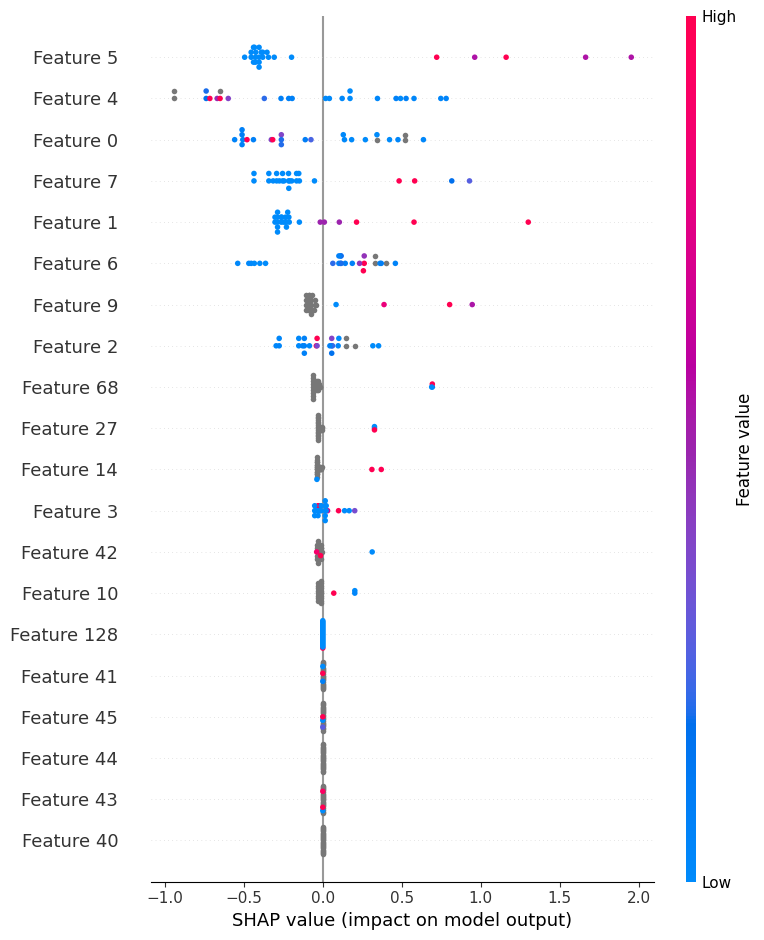

In [14]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)